In [ ]:
import yfinance as yf
import pandas as pd
import os

In [ ]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [ ]:
sp500.index = pd.to_datetime(sp500.index)

In [ ]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,0,0
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,0,0
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,0,0


<Axes: xlabel='Date'>

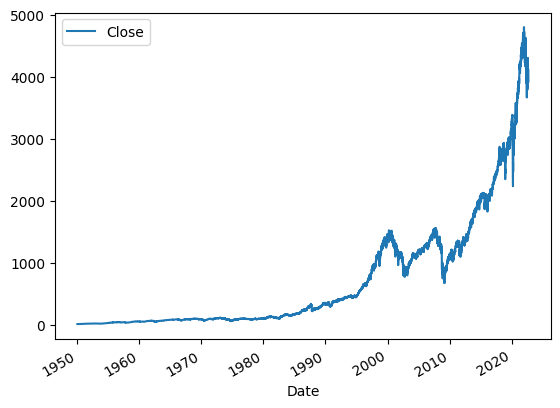

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [ ]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [ ]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
sp500 = sp500.loc["2022-02-14":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

<Axes: xlabel='Date'>

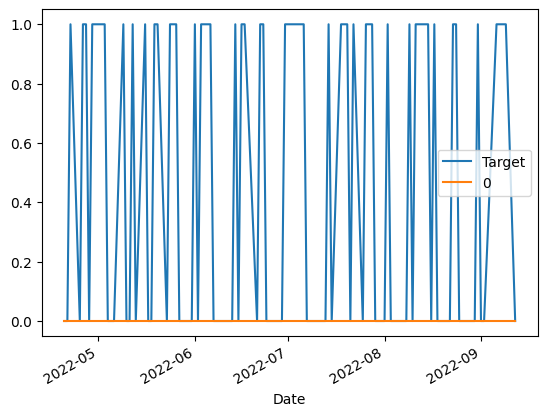

In [ ]:
combined= pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=20, step=100):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

0    125
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.52
1    0.48
Name: Target, dtype: float64

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [ ]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              0 non-null      float64
 1   High              0 non-null      float64
 2   Low               0 non-null      float64
 3   Close             0 non-null      float64
 4   Volume            0 non-null      int64  
 5   Tomorrow          0 non-null      float64
 6   Target            0 non-null      int64  
 7   Close_Ratio_2     0 non-null      float64
 8   Trend_2           0 non-null      float64
 9   Close_Ratio_5     0 non-null      float64
 10  Trend_5           0 non-null      float64
 11  Close_Ratio_60    0 non-null      float64
 12  Trend_60          0 non-null      float64
 13  Close_Ratio_250   0 non-null      float64
 14  Trend_250         0 non-null      float64
 15  Close_Ratio_1000  0 non-null      float64
 16  Trend_1000        0 non-null      float64
dtypes: flo

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions["Predictions"].value_counts()

0    125
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.52
1    0.48
Name: Target, dtype: float64

In [ ]:
predictions

,Target,Predictions
Date,,
2022-03-15,1,0
2022-03-16,1,0
2022-03-17,1,0
2022-03-18,0,0
2022-03-21,1,0
...,...,...
2022-09-06,1,0
2022-09-07,1,0
2022-09-08,1,0
